In [2]:
import numpy as np
import sympy as sp
import matplotlib
import random
import matplotlib.pyplot as plt
import matplotlib.tri as mtri
%matplotlib inline 
%precision 5

'%.5f'

# Reading a mesh and doing some simple calculations

The videos from the discretization of 2D geometries using finite elements introduced first the triangle elements. For these elements, it is possible to get the basis functions directly in terms of $x$ and $y$, so we start here with those. However, similar to the notebook for the 1D shape functions, the most common way of defining the basis functions is in a parent domain and then use the isoparametric map, so that is done in the second part of this notebook. 

For the linear triangle with shape functions in $x$ and $y$ the interpolation of any function $\theta^h$ can be done 

$\theta^h(x,y) = \sum_i^{nodes} N_i(x,y)\theta_i^e$ 

where the $N_i(x,y)$ are the shape functions corresponding to every node, and $\theta^e_i$ are the nodal values of the scalar field $\theta^h$. 

If the basis functions are directly in terms of $x$ and $y$ then the gradient of the $\theta^h$ field is 

$\nabla \theta^h = \sum_i^{nodes} \theta_i^e \nabla_x N_i(x,y)$ 

In [3]:
## Read in a mesh 
meshfile = open("frog_mesh.txt",'r').readlines()
n_node = int(meshfile[1])
node_X = np.zeros((n_node,2))
for i in range(n_node):
    aux = meshfile[2+i].split()
    node_X[i,0] = float(aux[0])
    node_X[i,1] = float(aux[1])
n_elem = int(meshfile[3+n_node])
elements = np.zeros((n_elem,3),dtype=int)
for i in range(n_elem):
    aux = meshfile[4+n_node+i].split()
    elements[i,0] = int(aux[0])
    elements[i,1] = int(aux[1])
    elements[i,2] = int(aux[2])
#print(node_X)
#print(elements)
print(n_node)
print(n_elem)

455
649


In [4]:
## shape function
## gradient of shape functions

def N1(x,y,x1,y1,x2,y2,x3,y3):
    Ae = Area(x1,y1,x2,y2,x3,y3)
    return (1./2./Ae)*(x2*y3-x3*y2+(y2-y3)*x+(x3-x2)*y)

def N2(x,y,x1,y1,x2,y2,x3,y3):
    Ae = Area(x1,y1,x2,y2,x3,y3)
    return (1./2./Ae)*(x3*y1-x1*y3+(y3-y1)*x+(x1-x3)*y)

def N3(x,y,x1,y1,x2,y2,x3,y3):
    Ae = Area(x1,y1,x2,y2,x3,y3)
    return (1./2./Ae)*(x1*y2-x2*y1+(y1-y2)*x+(x2-x1)*y)

def Gradient_N1(x1,y1,x2,y2,x3,y3):
    
    edge1 = np.array([x2-x1,y2-y1,0.])
    edge2 = np.array([x3-x1,y3-y1,0.])
    A_e = np.cross(edge1,edge2)
    A_e = np.linalg.norm(A_e)/2.
    
    dN1dx = (1./(2*A_e))*(y2-y3)
    dN1dy = (1./(2*A_e))*(x3-x2)
    
    return np.array([dN1dx,dN1dy])

def Gradient_N2(x1,y1,x2,y2,x3,y3):
    edge1 = np.array([x2-x1,y2-y1,0.])
    edge2 = np.array([x3-x1,y3-y1,0.])
    A_e = np.cross(edge1,edge2)
    A_e = np.linalg.norm(A_e)/2.
    
    dN2dx = (1./(2*A_e))*(y3-y1)
    dN2dy = (1./(2*A_e))*(x1-x3)
    
    return np.array([dN2dx,dN2dy])

def Gradient_N3(x1,y1,x2,y2,x3,y3):
    edge1 = np.array([x2-x1,y2-y1,0.])
    edge2 = np.array([x3-x1,y3-y1,0.])
    A_e = np.cross(edge1,edge2)
    A_e = np.linalg.norm(A_e)/2.
    
    dN3dx = (1./(2*A_e))*(y1-y2)
    dN3dy = (1./(2*A_e))*(x2-x1)
    return np.array([dN3dx,dN3dy])

def Area(x1,y1,x2,y2,x3,y3):
    edge1 = np.array([x2-x1,y2-y1,0.])
    edge2 = np.array([x3-x1,y3-y1,0.])
    A_e = np.cross(edge1,edge2)
    A_e = np.linalg.norm(A_e)/2.
    return A_e



### Test

Consider a couple of functions for which we have analaytical expressions $f_1(x,y)$ and $f_2(x,y)$. We are going to evalue the function at the nodes and store those values, then use only the nodal values to compute the interpolation and the gradients, and compare against the analytical gradient $\mathrm{d}f_1/\mathrm{d}x$ and $\mathrm{d}f_2/\mathrm{d}x$

In [14]:
def func1(x,y):
    a = 0.25
    b = 1.
    return 4.*a/np.sqrt(x**2 + y**2) - 4. - 2*a*x**2/np.sqrt((x**2 + y**2)**3)- 2*a*y**2/np.sqrt((x**2 + y**2)**3)

def func2(x,y):
    return x*y

def gradfunc2(x,y):
    return np.array([y,x])

In [8]:
# create a vector with the values of the function at the nodes 
func2_over_nodes = np.zeros((n_node))
for i in range(n_node):
    func2_over_nodes[i] = func2(node_X[i,0],node_X[i,1])

In [15]:
# For the frog: loop over elements and get a vector with the value of func2 at the center of the elements 

func2_over_elements_v1 = np.zeros((n_elem))
func2_over_elements_v2 = np.zeros((n_elem))
gradx_func2_over_elements_v1 = np.zeros((n_elem,2))
gradx_func2_over_elements_v2 = np.zeros((n_elem,2))
## Loop over elements
for i in range(n_elem):
    # Get the nodes making up this element
    node1 = elements[i,0]
    node2 = elements[i,1]
    node3 = elements[i,2]
    # Get the coordinates of the triangle
    x1 = node_X[node1,0]
    y1 = node_X[node1,1]
    x2 = node_X[node2,0]
    y2 = node_X[node2,1]
    x3 = node_X[node3,0]
    y3 = node_X[node3,1]
    # Call function to evaluate the gradient of shape functions 
    GradN1e = Gradient_N1(x1,y1,x2,y2,x3,y3)
    GradN2e = Gradient_N2(x1,y1,x2,y2,x3,y3)
    GradN3e = Gradient_N3(x1,y1,x2,y2,x3,y3)
    # Area, if you need it
    A_e = Area(x1,y1,x2,y2,x3,y3)
    # interpolate at the center of the element 
    x = 1./3*(x1+x2+x3)
    y = 1./3*(y1+y2+y3)
    # analytical expression
    func2_over_elements_v1[i] = func2(x,y)
    # interpolation with shape functions 
    func2_over_elements_v2[i] =  N1(x,y,x1,y1,x2,y2,x3,y3)*func2_over_nodes[node1]+\
                                 N2(x,y,x1,y1,x2,y2,x3,y3)*func2_over_nodes[node2]+\
                                 N3(x,y,x1,y1,x2,y2,x3,y3)*func2_over_nodes[node3]
    # analytical gradient
    gradx_func2_over_elements_v1[i] = gradfunc2(x,y)
    # interpolated gradient 
    gradx_func2_over_elements_v2[i] = GradN1e*func2_over_nodes[node1]+\
                                      GradN2e*func2_over_nodes[node2]+\
                                      GradN3e*func2_over_nodes[node3]

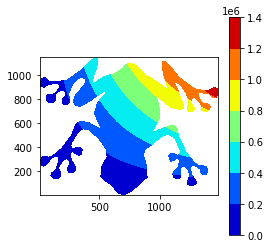

In [21]:
#fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(10,4))
plt.figure(figsize=(4,4))
plt.gca().set_aspect('equal')
#levels = [-0.00001, 0.2, 0.4, 0.6, 0.8, 1., 1.2,1.4]
plt.tricontourf(node_X[:,0],node_X[:,1] ,  elements, func2_over_nodes,cmap='jet')
plt.colorbar()

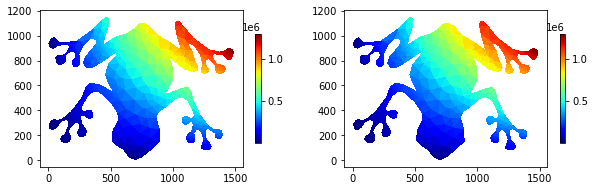

In [20]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(10,4))
p1=ax1.tripcolor(node_X[:,0],node_X[:,1] ,  elements, facecolors=func2_over_elements_v1 ,cmap='jet')
ax1.set_aspect('equal')
p2=ax2.tripcolor(node_X[:,0],node_X[:,1] ,  elements, facecolors=func2_over_elements_v2 ,cmap='jet')
ax2.set_aspect('equal')

plt.colorbar(p2,ax=ax2,shrink=0.5)
plt.colorbar(p1,ax=ax1,shrink=0.5)

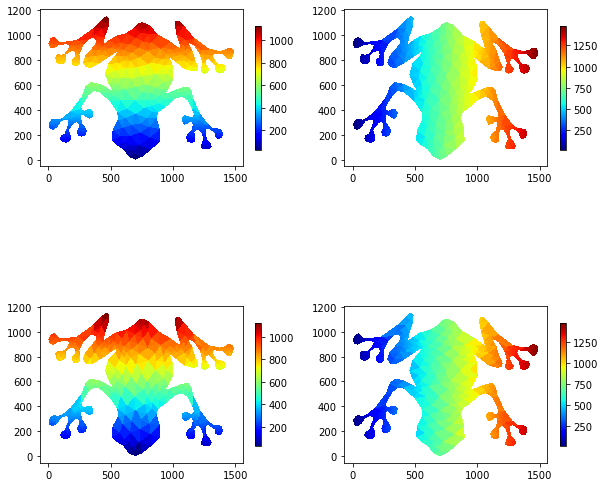

In [24]:
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2, 2, figsize=(10,10))
p1=ax1.tripcolor(node_X[:,0],node_X[:,1] ,  elements, facecolors=gradx_func2_over_elements_v1[:,0] ,cmap='jet')
ax1.set_aspect('equal')
p2=ax2.tripcolor(node_X[:,0],node_X[:,1] ,  elements, facecolors=gradx_func2_over_elements_v1[:,1] ,cmap='jet')
ax2.set_aspect('equal')
plt.colorbar(p2,ax=ax2,shrink=0.5)
plt.colorbar(p1,ax=ax1,shrink=0.5)

p3=ax3.tripcolor(node_X[:,0],node_X[:,1] ,  elements, facecolors=gradx_func2_over_elements_v2[:,0] ,cmap='jet')
ax3.set_aspect('equal')
p4=ax4.tripcolor(node_X[:,0],node_X[:,1] ,  elements, facecolors=gradx_func2_over_elements_v2[:,1] ,cmap='jet')
ax4.set_aspect('equal')
plt.colorbar(p4,ax=ax4,shrink=0.5)
plt.colorbar(p3,ax=ax3,shrink=0.5)

# Isoparametric map 

For the linear triangle, we can have shape functions defined in terms of the $\xi$ and $\eta$ coordinates. 
We would have $N_1(\xi,\eta), N_2(\xi,\eta), N_3(\xi,\eta)$, with 

$N_1(\xi,\eta) = 1-\xi-\eta$

$N_2(\xi,\eta) = \xi$

$N_3(\xi,\eta) = \eta$

The isoparametric map is 

$\mathbf{x} = \sum_i N_i(\mathbf{\xi})\mathbf{x}_i^e$

where $\mathbf{x}_i^e$ are the nodal coordinates of the triangle. There is only one constraint, which is that the nodes need to be numbered counter-clockwise. Given the isoparametric map the gradient of that map is the Jacobian 

$\mathbf{J} = \nabla_\xi \mathbf{x} = \sum_i \mathbf{x}_i^e \otimes \nabla_\xi N_i(\mathbf{\xi})$

We can use this Jacobian to compute derivatives with respect to $\mathbf{x}$ in the following way 

$\nabla_x N_i = \mathbf{J}^{-T} \nabla_\xi N_i$

And using these gradients we can calculate gradients of any function $g$ given its nodal values $g_i^e$

$\nabla_x g = \sum g_i^e \nabla_x N_i$

In [28]:
def N1(xi,eta):
    return 1-xi-eta 
def N2(xi,eta):
    return xi
def N3(xi,eta):
    return eta
def gradxi_N1(xi,eta):
    return np.array([[-1,-1]])
def gradxi_N2(xi,eta):
    return np.array([[1,0]])
def gradxi_N3(xi,eta):
    return np.array([[0,1]])

In [40]:
# For the frog: loop over elements and get a vector with the value of func2 at the center of the elements 
# this time using the parent domain shape functions 
func2_over_elements_v2 = np.zeros((n_elem))
## Loop over elements
for i in range(n_elem):
    # Get the nodes making up this element
    node1 = elements[i,0]
    node2 = elements[i,1]
    node3 = elements[i,2]
    # Get the coordinates of the triangle
    x1 = node_X[node1,0]
    y1 = node_X[node1,1]
    x2 = node_X[node2,0]
    y2 = node_X[node2,1]
    x3 = node_X[node3,0]
    y3 = node_X[node3,1]
    
    # Evaluate at a point in the parent domain xi,eta
    xi = 1./3 
    eta = 1./3 
    func2_over_elements_v2[i] =  N1(xi,eta)*func2_over_nodes[node1]+\
                                 N2(xi,eta)*func2_over_nodes[node2]+\
                                 N3(xi,eta)*func2_over_nodes[node3]
    # To calculate gradients we need the Jacobian 
    Jmat = np.outer(np.array([x1,y1]),gradxi_N1(xi,eta)) +\
           np.outer(np.array([x2,y2]),gradxi_N2(xi,eta)) +\
           np.outer(np.array([x3,y3]),gradxi_N3(xi,eta))
    # and the inverse transpose of the Jacobian 
    JinvT = np.linalg.inv(Jmat).transpose()
    # use this to get gradient of shape functions with respect to x and y 
    gradx_N1 = np.dot(JinvT,gradxi_N1(xi,eta).transpose())
    gradx_N2 = np.dot(JinvT,gradxi_N2(xi,eta).transpose())
    gradx_N3 = np.dot(JinvT,gradxi_N3(xi,eta).transpose())
    # finally use the gradients of shape functions with respect to x to get gradient of func2 with respect to x
    gradx_func2_over_elements_v2[i] = (gradx_N1*func2_over_nodes[node1]+\
                                      gradx_N2*func2_over_nodes[node2]+\
                                      gradx_N3*func2_over_nodes[node3]).transpose()

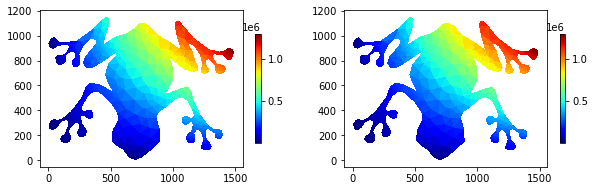

In [41]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(10,4))
p1=ax1.tripcolor(node_X[:,0],node_X[:,1] ,  elements, facecolors=func2_over_elements_v1 ,cmap='jet')
ax1.set_aspect('equal')
p2=ax2.tripcolor(node_X[:,0],node_X[:,1] ,  elements, facecolors=func2_over_elements_v2 ,cmap='jet')
ax2.set_aspect('equal')

plt.colorbar(p2,ax=ax2,shrink=0.5)
plt.colorbar(p1,ax=ax1,shrink=0.5)

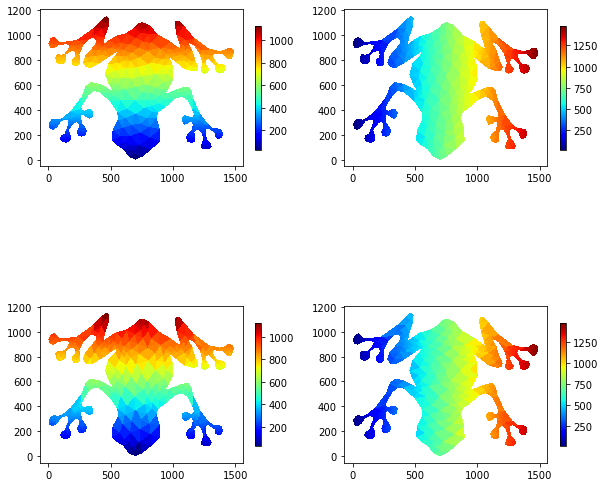

In [42]:
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2, 2, figsize=(10,10))
p1=ax1.tripcolor(node_X[:,0],node_X[:,1] ,  elements, facecolors=gradx_func2_over_elements_v1[:,0] ,cmap='jet')
ax1.set_aspect('equal')
p2=ax2.tripcolor(node_X[:,0],node_X[:,1] ,  elements, facecolors=gradx_func2_over_elements_v1[:,1] ,cmap='jet')
ax2.set_aspect('equal')
plt.colorbar(p2,ax=ax2,shrink=0.5)
plt.colorbar(p1,ax=ax1,shrink=0.5)

p3=ax3.tripcolor(node_X[:,0],node_X[:,1] ,  elements, facecolors=gradx_func2_over_elements_v2[:,0] ,cmap='jet')
ax3.set_aspect('equal')
p4=ax4.tripcolor(node_X[:,0],node_X[:,1] ,  elements, facecolors=gradx_func2_over_elements_v2[:,1] ,cmap='jet')
ax4.set_aspect('equal')
plt.colorbar(p4,ax=ax4,shrink=0.5)
plt.colorbar(p3,ax=ax3,shrink=0.5)